# Compute a p-value - look at the effect size

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.stats as sst

from IPython.display import Image as Image
from IPython.display import display as display


## Create a normal distribution

In [2]:
np.random.seed(42) # 42 is arbitrary 

In [3]:
# define the normal 0,1 object
norm01 = sst.norm(0,1)
# Let's fix the seed of the random generator
sample_size = (30,)
sample = norm01.rvs(size=sample_size)


In [4]:
# compute mean and corrected standard deviation
sample_mean = sample.mean()
#sample_std_biased = sample.std()
sample_std = np.sqrt(np.var(sample, ddof=1))
# print(sample_std,sample_std_biased)
N = len(sample)

print("sample mean: ",sample_mean, "sample_std: ", sample_std)

sample mean:  -0.18814689585103744 sample_std:  0.9000064274024113


## compute the t-value and corresponding p-value

In [5]:
t_value = sample_mean / (sample_std/np.sqrt(N))
print(t_value)

-1.1450173670383308


In [6]:
def t_value_from_sample(sample):
    """
    Take a sample of data (numpy array) return t-value
    """
    
    N = len(sample)
    sample_mean = sample.mean()
    sample_std = np.sqrt(np.var(sample,ddof=1))
    t_val = sample_mean / (sample_std/np.sqrt(N))
    return t_val
    

In [7]:
print(t_value_from_sample(sample))

-1.1450173670383308


In [8]:
N = len(sample)
p_val = sst.t.sf(t_value_from_sample(sample), df=N-1)
print(p_val)

0.8692179269059926


## Do this for a number of experiments

In [9]:
sample_size = 16
distrib = sst.norm(.22, 1)
nb_of_experiments = 20
alpha = 0.05

effect_size = []

for idx in range(nb_of_experiments):
    sample =  distrib.rvs(size=(sample_size,))
    t_val = t_value_from_sample(sample)
    p_val = sst.t.sf(t_value_from_sample(sample), df=sample_size-1)
    signif = int(p_val <= alpha)
    print(t_val, "\t\t", p_val,"\t",  "*"*signif, )
    if signif:
        effect_size.append(sample.mean())

print('\n Effect_size corresponding to "significant" p-values: \n', effect_size) 

-0.3247988362898721 		 0.6250904849985869 	 
1.2530267645200586 		 0.11468877706432458 	 
1.2092638701650305 		 0.1226385607982357 	 
0.7997358692172131 		 0.2181731653597513 	 
0.4822699511761343 		 0.31828794740174343 	 
1.5385040864654462 		 0.07237550973643124 	 
0.035854079004229246 		 0.48593575287950336 	 
0.9720601297593314 		 0.17321796146408253 	 
1.2906284684981664 		 0.1081860088830261 	 
1.5056302576436764 		 0.07646401166758537 	 
0.7204561839743074 		 0.24116075125473568 	 
2.275384713794134 		 0.018993338507574585 	 *
0.47051045361119004 		 0.32237952923305385 	 
1.5843729008305771 		 0.06698057289064367 	 
-0.7485738483641617 		 0.7671546243267946 	 
1.0326058469136885 		 0.15907549474565894 	 
1.656259700265945 		 0.05921663097464693 	 
4.2902934464293 		 0.0003221320115904162 	 *
1.447453035470622 		 0.08417327229740135 	 
-0.6934482092557347 		 0.7506867837231845 	 

 Effect_size corresponding to "significant" p-values: 
 [0.7316506050605452, 0.6389548995517084]


In [10]:
print(np.asanyarray(effect_size).mean(), np.asanyarray(effect_size).std())

0.6853027523061268 0.04634785275441844


## Relate this to bias and file drawer effect

# The p-hacking problem

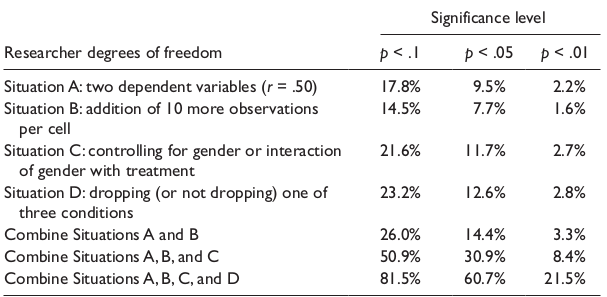

In [11]:
img = Image('./figures/simons_table.png')
display(img)

# Revise alpha 

### Recent and less recent attempts to change the standard alpha

Johnson, V.E. (2013). Revised standards for statistical evidence. PNAS 110, 19313–19317.


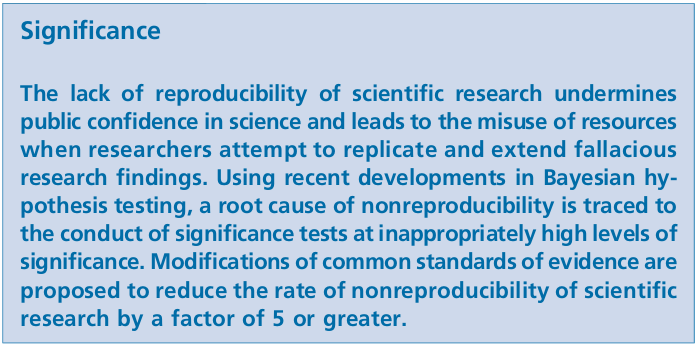

In [12]:
print("Johnson, V.E. (2013). Revised standards for statistical evidence. " + 
                             "PNAS 110, 19313–19317.")
Image('./figures/johnson_PNAS_2013_significance.png')


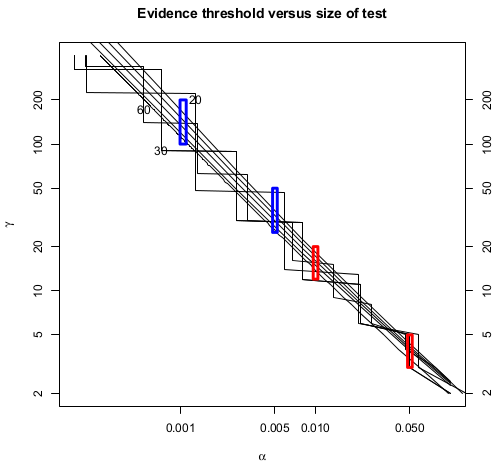

In [13]:
Image('./figures/johnson_PNAS_2013_pval_bayefct.png')


## Quick effect size reminder

### What is the effect ?


$$\hspace{3cm}\mu = \mu_1 - \mu_2$$

### What is the standardized effect ? (eg Cohen's d)

$$\hspace{3cm}d = \frac{\mu_1 - \mu_2}{\sigma} = \frac{\mu}{\sigma}$$

### "Z" : Effect accounting for the sample size 

$$\hspace{3cm}Z = \frac{\mu}{\sigma / \sqrt{n}}$$

### Cohen's d value:

In [14]:
# print some cohen values
# %pylab inline
muse = (.05, .1,.2,.3,.4,.5);
sigmas = np.linspace(1.,.5,len(muse))
cohenstr = ["For sigma = %3.2f and m = %3.2f Cohen d = %3.2f" %(sig,mu,coh) 
       for (sig,mu,coh) in zip(sigmas,muse, np.asarray(muse)/sigmas)]
for s in cohenstr:
    print(s)

For sigma = 1.00 and m = 0.05 Cohen d = 0.05
For sigma = 0.90 and m = 0.10 Cohen d = 0.11
For sigma = 0.80 and m = 0.20 Cohen d = 0.25
For sigma = 0.70 and m = 0.30 Cohen d = 0.43
For sigma = 0.60 and m = 0.40 Cohen d = 0.67
For sigma = 0.50 and m = 0.50 Cohen d = 1.00


We have to estimate the effect $\mu$ and the standard deviation $\sigma_{\mu}$, the t statistic would be:

$$
t = \frac{\hat{\mu}}{\hat{\sigma_{\mu}}} 
$$

Where $\hat{\sigma_{\mu}}$ is estimated with the standard deviation of the data Y and the number of sample $n$ : $\hat{\sigma_{Y}}/\sqrt{n}$ 

## Confidence intervals

$$ P\left(\bigg|\frac{\bar{Y} - \mu}{\hat\sigma/\sqrt{n}}\bigg| \leq t_{0.025}\right) = 0.05 $$ 

$$ P\left( -t_{0.025}\hat\sigma/\sqrt{n} + \bar{Y}  \leq \mu \leq t_{0.025}\hat\sigma/\sqrt{n} + \bar{Y}   \right) = 0.05 $$ 

In [15]:
def confidence_intervals(Nexp, CI = .95, **prmtrs):
    """
    Nexp: the number of experiments done
    CI: confidence interval
    
    prmtrs: a dictionary with our parameters, 
        example: prmtrs = {'n':16, 'mu':.3, 'sigma': 1., 'alpha': 0.05}
        
    returns arrays of size Nexp with:
    effect: the estimated effect
    detect: an array of 0 or 1, 1 when the effect is detected at alpha
    lCI: lower bound of confidence interval
    uCI: upper bound of confidence interval
    """
    # unpack parameters:
    n = prmtrs['n']
    mu = prmtrs['mu']; 
    alpha = prmtrs['alpha']; 
    sigma = prmtrs['sigma']
    df = n-1
    theta = mu*np.sqrt(n)/sigma
    
    # initialize arrays
    t = np.zeros((Nexp,))
    effect = np.zeros((Nexp,))
    lCI = np.zeros((Nexp,))
    uCI = np.zeros((Nexp,))

    # compute random variables and thresholds
    norv = sst.norm(0., sigma)
    strv = sst.t(df)
    # get the 0.05 t value *under the null* to construct confidence interval
    
    t_ci = strv.isf((1-CI)/2)
    # get the alpha level t value *under the null* to detect 
    t_alph = strv.isf(alpha)

    for experim in range(Nexp):
        # get n sample
        sample = norv.rvs(size=(n,)) + mu
        # effect and normalized effect size
        effect[experim] = sample.mean()
        std_error_data = np.std(sample, ddof=1) 
        std_error_mean = std_error_data/np.sqrt(n) # np.std takes ddof as 
                                                    # the df of freedom lost, here: 1.
        t[experim] = effect[experim]/std_error_mean
        # confidence interval :
        CI_ = t_ci*std_error_mean
        lCI[experim] = effect[experim] - CI_ # t_alph # 
        uCI[experim] = effect[experim] + CI_ # t_alph # 

    # number of detection:
    detect = t>t_alph
#    print 'number of detections:', xd.shape

    return (effect, detect, lCI, uCI, t)

In [16]:
#---------------------- parameters ------------------#
prmtrs = {'n':10, 'mu': .30, 'sigma': 1., 'alpha': 0.05}

theta = prmtrs['mu']*np.sqrt(prmtrs['n'])/prmtrs['sigma']
print('Theta value %.3f \n' %theta)
#Pw = stat_power(prmtrs['n'], prmtrs['mu'], alpha=prmtrs['alpha'])


#--------------  simulate Nexp experiments ---------#
Nexp = 1000
effect, detect, lCI, uCI, t = confidence_intervals(Nexp, CI=.95, **prmtrs)
print('Average t {:.3f} \n'.format(t.mean()))


#print("Compare power {:.3} and rate of detection {:.3} ".format(Pw, detect.sum()/Nexp))

print("Mean effect {:.3f} compared to average detected effect {:.3f} \n".format(
                    effect.mean(), effect[detect].mean()))

print("\n-------------- on detections")

print("-- # of exp. where lower bound > mu: {}".format((lCI[detect]>prmtrs['mu']).sum()))
print("-- # of exp. where upper bound < mu: {}".format((uCI[detect]<prmtrs['mu']).sum()))
not_in_CI = (uCI[detect]<prmtrs['mu']).sum() + (lCI[detect]>prmtrs['mu']).sum()
print("-- Not in CI = {:.3f}".format(not_in_CI))
print("-- over {} of detections".format(detect.sum()))
print("-- percentage = {:.3f}".format(not_in_CI/detect.sum()))


print("\n-------------- all experiment, not only detected")

print("-- # of exp. where lower bound > mu: {}".format((lCI>prmtrs['mu']).sum()))
print("-- # of exp. where upper bound < mu: {}".format((uCI<prmtrs['mu']).sum()))
print("-- over {} experiments".format(Nexp))
print("-- percentage = {:.3f}".format(
      ((lCI>prmtrs['mu']).sum() + (uCI<prmtrs['mu']).sum())/Nexp))

Theta value 0.949 

Average t 1.026 

Mean effect 0.298 compared to average detected effect 0.676 


-------------- on detections
-- # of exp. where lower bound > mu: 17
-- # of exp. where upper bound < mu: 0
-- Not in CI = 17.000
-- over 220 of detections
-- percentage = 0.077

-------------- all experiment, not only detected
-- # of exp. where lower bound > mu: 17
-- # of exp. where upper bound < mu: 23
-- over 1000 experiments
-- percentage = 0.040


lCI > mu :  0.0773, compare with 0.05 
1000


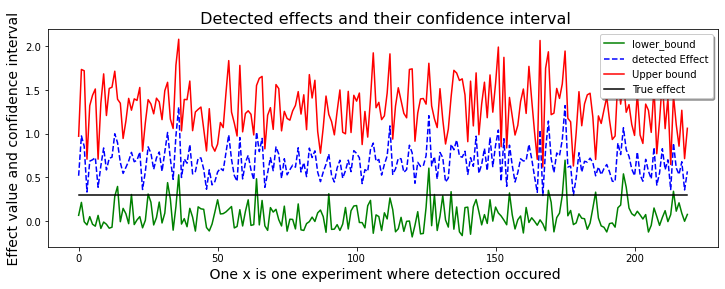

In [17]:
#--------------  plot ------------------------------#
mu = prmtrs['mu']
x = np.arange(Nexp)
xd = np.arange(detect.sum())
mu_line = np.ones((Nexp,))*prmtrs['mu']

# print the number of lower confidence interval values that are above the true mean:
# this should be about the risk of error/2
print("lCI > mu :  {:.3}, compare with {:.3} ".format( 
                (lCI > mu).sum() / (1.*detect.sum()),  prmtrs['alpha'])) #
print(Nexp)
# there should be none of these:
# print "(lCI < 0 ", (lCI[detect] < 0).sum() / detect.sum()

f = plt.figure(1).set_size_inches(12,4)
lines = plt.plot(xd, lCI[detect], 'g-', 
                 xd, effect[detect], 'b--',
                 xd, uCI[detect], 'r-',
                 xd, mu_line[detect], 'k');
plt.legend( lines, ('lower_bound','detected Effect', 'Upper bound', 'True effect'), 
                   loc='upper right', shadow=True)
plt.xlabel(" One x is one experiment where detection occured", fontdict={'size':14})
plt.ylabel(" Effect value and confidence interval ", fontdict={'size':14})
plt.title(" Detected effects and their confidence interval", fontdict={'size':16});

## What happens if ...

### Type I error is stricter 


### sample size goes down